# Notebook: Create Corpus Analysis 

This notebook is used to create plots using our trained model.
<br>**Contributors:** [Nils Hellwig](https://github.com/NilsHellwig/) | [Markus Bink](https://github.com/MarkusBink/)

## Packages

In [10]:
from plots import plot_overall_sentiment, plot_sentiment
import matplotlib.pyplot as plt
import pandas as pd
import random

## Parameters

In [11]:
PLOTS_PATH = "../Plots/"

## Code

### Create Figure with Bar Charts (Overall Sentiment Distribution)

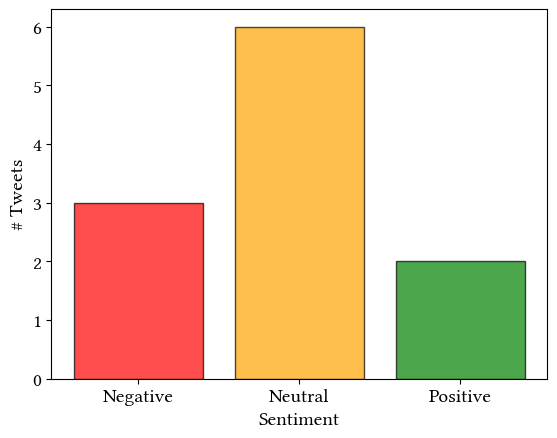

In [12]:
data = [3, 6, 2]
filename = PLOTS_PATH + "overall_sentiment"
plot_overall_sentiment(data, filename)

### Create Figure for Percentage Distribution of Sentiment Classes

In [15]:
N = 100
from datetime import datetime, timedelta
def random_date_2021():
    # Start date
    start = datetime(2021, 1, 1)
    # End date
    end = datetime(2021, 12, 31)
    # Get a random timedelta between the start and end date
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = random.randint(0, int_delta)
    # Add the random timedelta to the start date
    result = start + timedelta(seconds=random_second)
    # Return the date in the desired format
    return result.strftime("%Y-%m-%d %H:%M:%S")

sentiment = ['positive', 'negative', 'neutral'] * N * 18
party = ['CDU/CSU', 'SPD', 'AfD', 'FDP', 'Die Linke', 'Grüne'] * 9 * N
dates_array = [random_date_2021() for i in range(N * 18 * 3)]
random.shuffle(sentiment)
random.shuffle(party)
data = {'sentiment': sentiment, 'party': party, 'date': dates_array}
df = pd.DataFrame(data)
df

,sentiment,party,date
0,neutral,Die Linke,2021-12-13 07:29:27
1,positive,Grüne,2021-04-11 14:00:38
2,neutral,AfD,2021-08-22 20:14:20
3,negative,Grüne,2021-01-01 02:44:20
4,positive,SPD,2021-08-13 06:12:30
...,...,...,...
5395,positive,FDP,2021-06-21 05:12:53
5396,negative,FDP,2021-06-14 04:12:07
5397,positive,Die Linke,2021-12-28 02:00:58
5398,positive,Grüne,2021-09-12 02:20:08


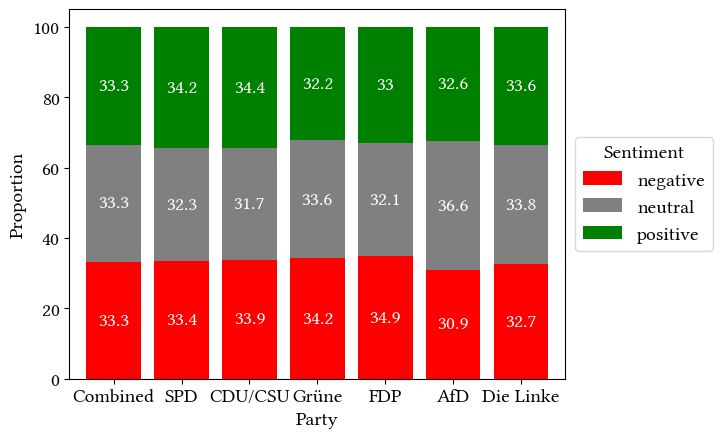

In [16]:
filename = PLOTS_PATH + "proportion_sentiment_parties"
plot_sentiment(df, filename)

### Mean Sentiment per month for the political parties over the whole election year